In [2126]:
import pandas as pd 
from random import gauss as gs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.dates as mdates
import matplotlib as mpl
import seaborn as sns
from math import sqrt

import itertools
#from pmdarima import auto_arima

#statsmodels

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_predict
import statsmodels.api as sm

%matplotlib inline

In [2127]:
crude_oil = pd.read_csv("data/crude_oil.csv")
gold = pd.read_csv("data/gold.csv")
dow_jones = pd.read_csv("data/dow_jones.csv")
fed_funds = pd.read_csv("data/fed_funds.csv")

crude_oil['Crude Oil'] = crude_oil['real']
crude_oil = crude_oil.drop(['real', 'nominal'], axis = 1)
crude_oil['date'] = pd.to_datetime(crude_oil['date'])
crude_oil.set_index('date', inplace = True)


gold['Gold'] = gold['real']
gold = gold.drop(['real', 'nominal'], axis = 1)
gold['date'] = pd.to_datetime(gold['date'])
gold.set_index('date', inplace = True)

dow_jones['Dow Jones'] = dow_jones['real']
dow_jones = dow_jones.drop(['real', 'nominal'], axis = 1)
dow_jones['date'] = pd.to_datetime(dow_jones['date'])
dow_jones.set_index('date', inplace = True)

fed_funds['date'] = fed_funds['DATE']
fed_funds['Fed Funds'] = fed_funds['FEDFUNDS']
fed_funds = fed_funds.drop(['DATE', 'FEDFUNDS'], axis = 1)
fed_funds['date'] = pd.to_datetime(fed_funds['date'])
fed_funds.set_index('date', inplace = True)

fed_funds

,Fed Funds
date,
1954-07-01,0.80
1954-08-01,1.22
1954-09-01,1.07
1954-10-01,0.85
1954-11-01,0.83
...,...
2022-01-01,0.08
2022-02-01,0.08
2022-03-01,0.20


,Dow Jones,Gold,Crude Oil,Fed Funds
date,,,,
1915-01-01,1636.27,557.10,NaN,NaN
1915-02-01,1608.23,562.68,NaN,NaN
1915-03-01,1796.01,568.36,NaN,NaN
1915-04-01,2098.13,562.68,NaN,NaN
1915-05-01,1881.39,557.10,NaN,NaN
...,...,...,...,...
2022-02-01,34909.38,1957.72,98.59,0.08
2022-03-01,35267.88,1986.24,101.98,0.20
2022-04-01,33339.96,1932.73,105.84,0.33


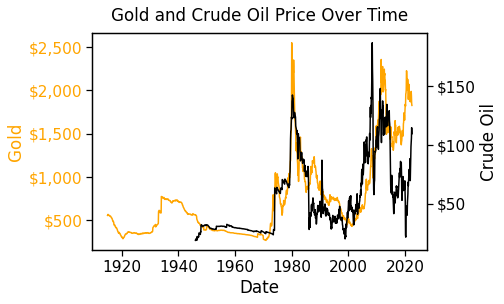

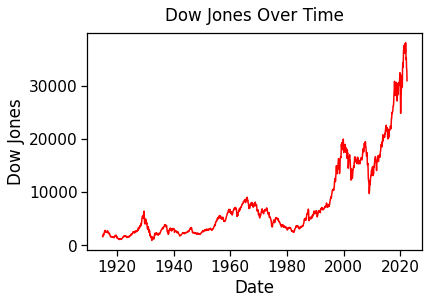

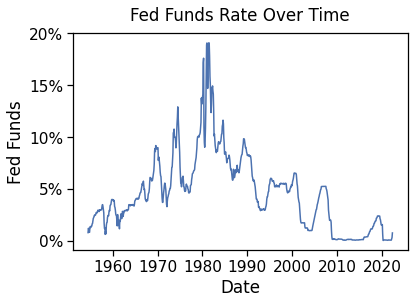

In [2128]:
all_data = dow_jones.copy()
all_data['Gold'] = gold['Gold']
#all_data = all_data[400:]
#all_data['Crude Oil'] = crude_oil['Crude Oil']

all_data = pd.concat([all_data, crude_oil, fed_funds], axis=1)
#all_data = pd.concat([all_data, fed_funds], axis=1)
#all_data['Fed Funds'] = fed_funds['Fed Funds']


#all_data.set_index('date', inplace = True)


fig, ax1 = plt.subplots()
ax1.set_title('Gold and Crude Oil Price Over Time', pad = 12) 
color = 'orange'
ax1.set_xlabel('Date')
ax1.set_ylabel('Gold', color = color)
ax1.plot(all_data.index, all_data['Gold'], color = color)
ax1.tick_params(axis ='y', labelcolor = color)
ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
 
# Adding Twin Axes to plot using dataset_2
ax2 = ax1.twinx()
 
color = 'black'
ax2.set_ylabel('Crude Oil', color = color)
ax2.plot(all_data.index, all_data['Crude Oil'], color = color)
ax2.tick_params(axis ='y', labelcolor = color)
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))


fig, ax3 = plt.subplots()
ax3.set_title('Dow Jones Over Time', pad = 12)
ax3.set_xlabel('Date')
color = 'red'
ax3.set_ylabel('Dow Jones')
ax3.plot(all_data.index, all_data['Dow Jones'], color = color)


fig, ax4 = plt.subplots()
ax4.set_title('Fed Funds Rate Over Time', pad = 12)
ax4.set_xlabel('Date')
ax4.set_ylabel('Fed Funds')
ax4.plot(all_data.index, all_data['Fed Funds'])
ax4.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}%'))

all_data



C:\Users\wjsdn\AppData\Local\Temp\ipykernel_19980\2911810606.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(all_data.corr(), dtype=np.bool))


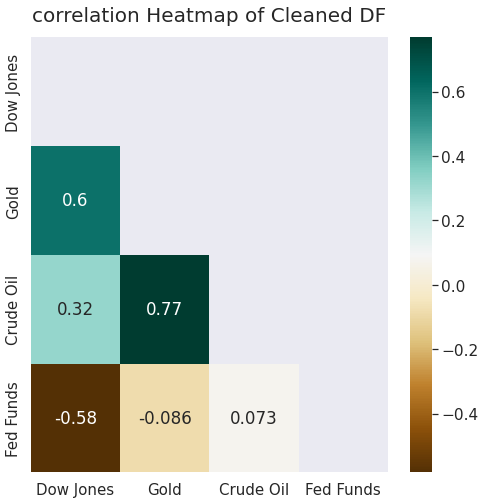

In [2129]:
with sns.axes_style('darkgrid'):
    
    f, ax = plt.subplots(figsize=(8,8))
    
    mask = np.triu(np.ones_like(all_data.corr(), dtype=np.bool))
    
    plt.xticks(fontsize = 15)
    
    plt.yticks(fontsize = 15)
    
    sns.set(font_scale=1.4)
    
    heatmap = sns.heatmap(all_data.corr(), annot = True, mask = mask, cmap = "BrBG")
    
    heatmap.set_title("correlation Heatmap of Cleaned DF", fontdict={'fontsize': 20}, pad =16)

In [2130]:
train_df = all_data['1990-07-01':'2021-05-01']
test_df = all_data['2021-06-01':'2022-05-01']

test_df

,Dow Jones,Gold,Crude Oil,Fed Funds
date,,,,
2021-06-01,37124.70,1906.24,79.05,0.08
2021-07-01,37415.89,1942.92,79.20,0.10
2021-08-01,37765.26,1939.27,73.16,0.09
2021-09-01,36077.62,1872.60,79.98,0.08
2021-10-01,37861.27,1885.58,88.33,0.08
2021-11-01,36276.87,1868.27,69.62,0.08
2021-12-01,38082.54,1916.37,78.82,0.08
2022-01-01,36537.13,1867.96,91.68,0.08
2022-02-01,34909.38,1957.72,98.59,0.08


In [2131]:
test_df_oil = test_df['Crude Oil']
test_df_oil = pd.DataFrame(test_df_oil)
test_df_oil

,Crude Oil
date,
2021-06-01,79.05
2021-07-01,79.20
2021-08-01,73.16
2021-09-01,79.98
2021-10-01,88.33
2021-11-01,69.62
2021-12-01,78.82
2022-01-01,91.68
2022-02-01,98.59


In [2143]:
train_df_oil = train_df['Crude Oil']
train_df_oil = pd.DataFrame(train_df_oil)
train_df_oil

,Crude Oil
date,
1990-07-01,46.39
1990-08-01,60.68
1990-09-01,87.04
1990-10-01,77.12
1990-11-01,63.04
...,...
2021-01-01,58.31
2021-02-01,68.33
2021-03-01,65.31


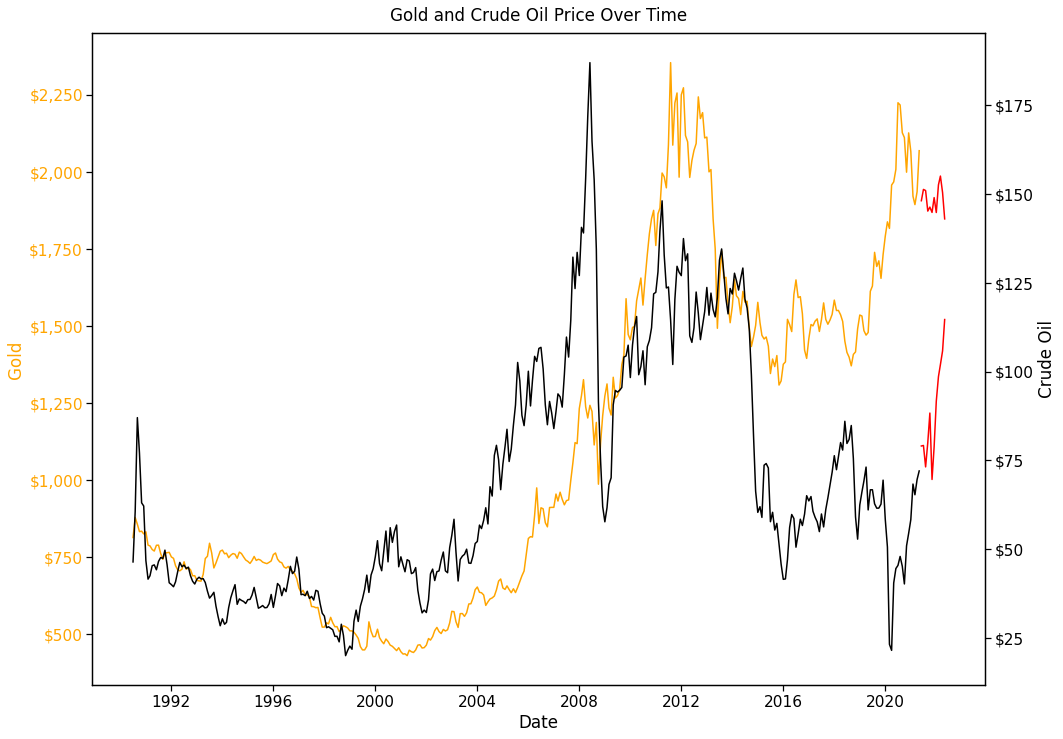

In [2132]:
gold = pd.DataFrame()

fig, ax1 = plt.subplots(figsize=(16,12))
ax1.set_title('Gold and Crude Oil Price Over Time', pad = 12) 
color = 'orange'
ax1.set_xlabel('Date')
ax1.set_ylabel('Gold', color = color)
ax1.plot(train_df.index, train_df['Gold'], color = color)
ax1.plot(test_df.index, test_df['Gold'], color = 'red')
ax1.tick_params(axis ='y', labelcolor = color)
ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
 
# Adding Twin Axes to plot using dataset_2
ax2 = ax1.twinx()
 
color = 'black'
ax2.set_ylabel('Crude Oil', color = color)
ax2.plot(train_df.index, train_df['Crude Oil'], color = color)
ax2.plot(test_df.index, test_df['Crude Oil'], color = 'red')
ax2.tick_params(axis ='y', labelcolor = color)
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))

In [2133]:
oil_train = train_df['Crude Oil']


oil_train_model = ARIMA(oil_train, order = (0,3,1))
oil_train_model_fit = oil_train_model.fit()
print(oil_train_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Crude Oil   No. Observations:                  371
Model:                 ARIMA(0, 3, 1)   Log Likelihood               -1332.617
Date:                Thu, 07 Jul 2022   AIC                           2669.234
Time:                        09:24:17   BIC                           2677.050
Sample:                    07-01-1990   HQIC                          2672.340
                         - 05-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9998      1.615     -0.619      0.536      -4.165       2.166
sigma2        80.5360    130.201      0.619      0.536    -174.653     335.725
Ljung-Box (L1) (Q):                  59.96   Jarque-

C:\Users\wjsdn\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [2134]:
oil_train_model_fit

In [2135]:
predict = oil_train_model_fit.predict()
oil_train_predict = pd.DataFrame(predict)
oil_train_predict

,predicted_mean
date,
1990-07-01,0.000000
1990-08-01,92.781245
1990-09-01,74.383557
1990-10-01,125.463889
1990-11-01,55.097781
...,...
2021-01-01,57.930450
2021-02-01,62.151491
2021-03-01,78.338395


In [2136]:
oil_fore = oil_train_model_fit.forecast(steps=100)
oil_fore = pd.DataFrame(oil_fore)
oil_fore

,predicted_mean
2021-06-01,74.387812
2021-07-01,76.723436
2021-08-01,79.026871
2021-09-01,81.298119
2021-10-01,83.537178
...,...
2029-05-01,152.552034
2029-06-01,151.829785
2029-07-01,151.075347
2029-08-01,150.288722


In [2137]:
oil_fore_error = oil_fore[:12]
oil_fore_error

,predicted_mean
2021-06-01,74.387812
2021-07-01,76.723436
2021-08-01,79.026871
2021-09-01,81.298119
2021-10-01,83.537178
2021-11-01,85.744049
2021-12-01,87.918732
2022-01-01,90.061227
2022-02-01,92.171534
2022-03-01,94.249652


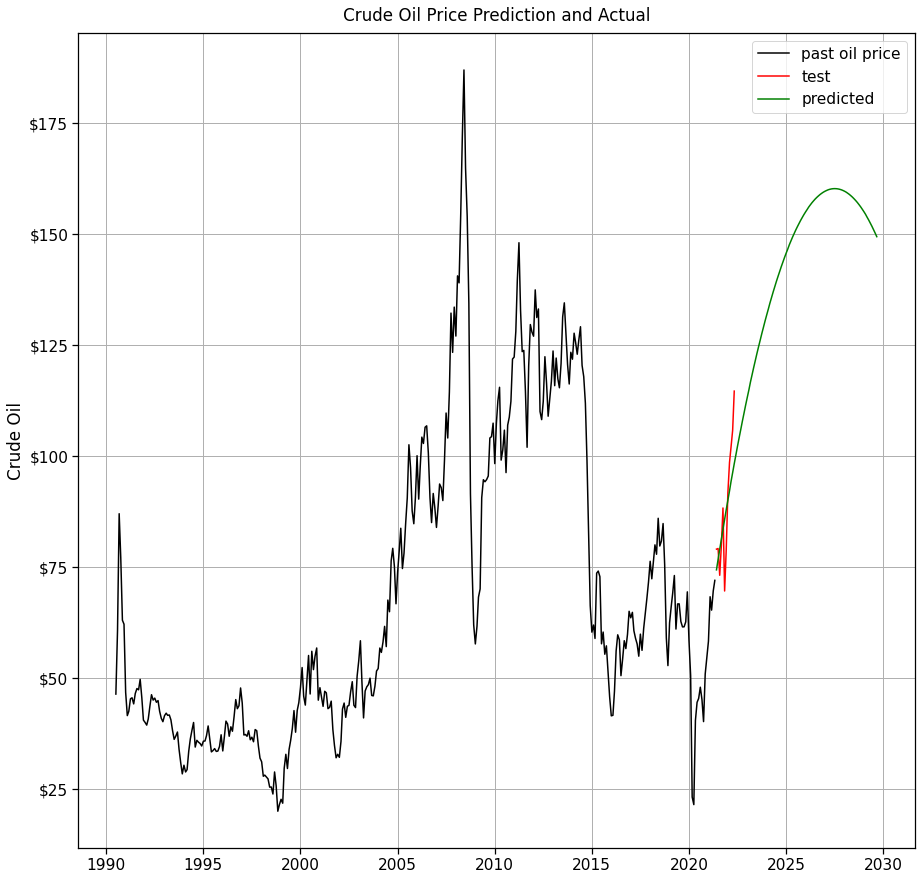

In [2138]:
fig, ax2 = plt.subplots(figsize=(15, 15))

ax2.set_title('Crude Oil Price Prediction and Actual', pad = 12) 
color = 'black'
ax2.set_ylabel('Crude Oil', color = color)
ax2.plot(train_df.index, train_df['Crude Oil'], color = color)
ax2.plot(test_df.index, test_df['Crude Oil'], color = 'red')
ax2.plot(oil_fore.index, oil_fore['predicted_mean'], color = 'green')
#ax2.plot(oil_train_predict, oil_train_predict['predicted_mean'], color = 'green')
ax2.tick_params(axis ='y', labelcolor = color)
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
plt.legend(['past oil price', 'test', 'predicted']);
plt.grid()

In [2141]:
rms_test = sqrt(mean_squared_error(test_df_oil, oil_fore_error))
rms_test

8.622224160000986

In [2146]:
rms_train = sqrt(mean_squared_error(train_df_oil, oil_train_predict))
rms_train

9.645492079222704

In [2097]:
from prophet import Prophet

In [2098]:
oil_df =all_data['2005-05-01':'2022-05-01']
oil_df['ds'] = oil_df.index
oil_df.rename(columns = {'Crude Oil' : 'y'}, inplace = True)
oil_df = oil_df.reindex(columns=['ds', 'y'])
oil_df

C:\Users\wjsdn\AppData\Local\Temp\ipykernel_19980\3372760790.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oil_df['ds'] = oil_df.index
C:\Users\wjsdn\AppData\Local\Temp\ipykernel_19980\3372760790.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oil_df.rename(columns = {'Crude Oil' : 'y'}, inplace = True)


,ds,y
date,,
2005-05-01,2005-05-01,78.16
2005-06-01,2005-06-01,84.92
2005-07-01,2005-07-01,90.61
2005-08-01,2005-08-01,102.58
2005-09-01,2005-09-01,97.37
...,...,...
2022-01-01,2022-01-01,91.68
2022-02-01,2022-02-01,98.59
2022-03-01,2022-03-01,101.98


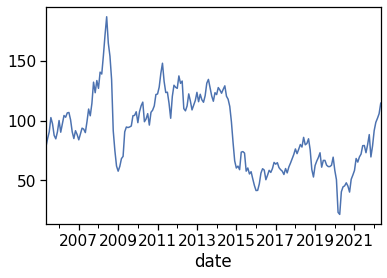

In [2099]:
ax = oil_df['y'].plot()
plt.show()

In [2100]:
oil_prophet = Prophet(changepoint_prior_scale = 1)
oil_prophet.fit(oil_df)

08:55:45 - cmdstanpy - INFO - Chain [1] start processing
08:55:45 - cmdstanpy - INFO - Chain [1] done processing


In [2101]:
forecast_time = 20
df_forecast = oil_prophet.make_future_dataframe(periods = forecast_time, freq = 'M')
df_forecast

,ds
0,2005-05-01
1,2005-06-01
2,2005-07-01
3,2005-08-01
4,2005-09-01
...,...
220,2023-08-31
221,2023-09-30
222,2023-10-31
223,2023-11-30


In [2102]:
df_forecast = oil_prophet.predict(df_forecast)
df_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2005-05-01,87.627118,77.099175,109.196331,87.627118,87.627118,5.432489,5.432489,5.432489,5.432489,5.432489,5.432489,0.0,0.0,0.0,93.059607
1,2005-06-01,87.772404,78.239888,112.445866,87.772404,87.772404,7.503010,7.503010,7.503010,7.503010,7.503010,7.503010,0.0,0.0,0.0,95.275415
2,2005-07-01,87.913004,77.157944,111.068093,87.913004,87.913004,5.935789,5.935789,5.935789,5.935789,5.935789,5.935789,0.0,0.0,0.0,93.848794
3,2005-08-01,88.058291,76.172061,110.576555,88.058291,88.058291,5.695208,5.695208,5.695208,5.695208,5.695208,5.695208,0.0,0.0,0.0,93.753499
4,2005-09-01,88.203577,74.908236,107.762485,88.203577,88.203577,3.704499,3.704499,3.704499,3.704499,3.704499,3.704499,0.0,0.0,0.0,91.908077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,2023-08-31,83.891796,46.348610,107.307216,57.008702,109.231088,-4.813127,-4.813127,-4.813127,-4.813127,-4.813127,-4.813127,0.0,0.0,0.0,79.078669
221,2023-09-30,84.396847,70.199672,140.362219,54.983113,112.217687,21.205941,21.205941,21.205941,21.205941,21.205941,21.205941,0.0,0.0,0.0,105.602788
222,2023-10-31,84.918732,57.671909,129.313796,51.637240,115.855380,7.738123,7.738123,7.738123,7.738123,7.738123,7.738123,0.0,0.0,0.0,92.656855
223,2023-11-30,85.423782,45.724869,125.827063,49.202320,119.394240,0.708842,0.708842,0.708842,0.708842,0.708842,0.708842,0.0,0.0,0.0,86.132624


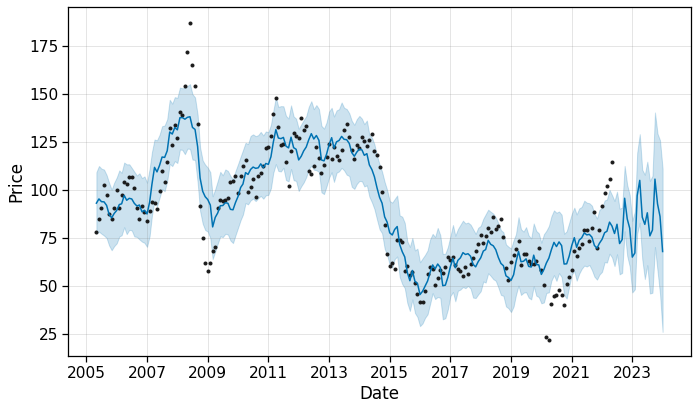

In [2115]:
oil_prophet.plot(df_forecast, xlabel = 'Date', ylabel = 'Price');

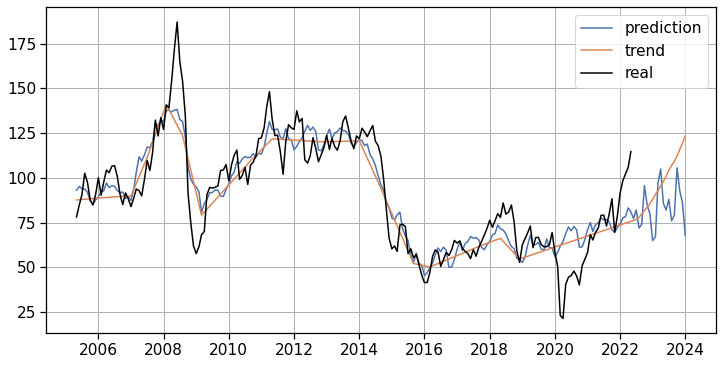

In [2104]:
plt.figure(figsize=(12,6))
plt.plot(df_forecast['ds'], df_forecast['yhat'], label = 'prediction')
plt.plot(df_forecast['ds'], df_forecast['trend_upper'], label = 'trend' )
#plt.plot(df_forecast['ds'], df_forecast['yhat_lower'], label = 'forecast' )
plt.plot(oil_df['ds'], oil_df['y'], label = 'real', color = 'black')
plt.legend()
plt.grid()